<h1 style="width:750px">Airbnb and the Prevalence of Ghost Hotels in London</h1>

---

| CASA0013 | Introduction to Programming for Spatial Analysts | 
|----|----|
| Programme | MSc Smart Cities and Urban Analytics |
| Bartlett | Centre for Advanced Spatial Analytics |
| Word Count | 2,500 |
| Student ID | 19140941 |
| Date | 21-01-13 |

---

## Part 1 - Reproducible Analysis

Data for this analysis was downloaded from the Inside Airbnb website at http://insideairbnb.com/get-the-data.html.

| Data Downloaded | |  | |
|----|----|----|----|
|  09 August, 2019  |  London  |  listings.csv.gz  |  Detailed Listings data for London  |
|  N/A  |  London  |  neighbourhoods.csv  |  Neighbourhood list for geo filtering  |
|  N/A  |  London  |  neighbourhoods.geojson  |  GeoJSON file of city neighbourhoods  |

**Note:** 
- With a file size of 318 MB, the original .csv file was too large for GitHub to accept. 
- The original data set contained 106 columns.
- 97 columns were removed and the remaining 9 columns were saved to a new .csv to be uploaded to GitHub.
- These steps were completed in Excel, but the python the code below could be run instead.

**Steps:**
- Load original .csv
- Create a new dataframe containing only the 9 columns needed for analysis
- Save the new datframe as a .csv file

**Code:**

In [5]:
# original = pd.read_csv('listings.csv')
# airbnb = original.loc[:, ['id', 'host_id', 'host_about', 'host_neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type']]
# airbnb.to_csv('<Path>\19-08_ab_london.csv', header=True)

- The resulting .csv file is used in the reproducible analysis below.
- The .csv file can be downloaded from GitHub at https://github.com/MattKavanaugh/I2P-Exec-Briefing. 

### Load

In [6]:
# Load libraries

import pandas as pd
import geopandas as gpd
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import sklearn

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Load dataframe

airbnb = pd.read_csv('19-08_ab_london.csv',encoding = "Latin-1")
airbnb.head()

,id,host_id,host_about,host_neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type
0,32722203,2697,"37 years old from France. Living with my wife,...",LB of Islington,Islington,51.55416,-0.10358,Apartment,Entire home/apt
1,32722192,4775,Hi\r\n\r\nI expect you'd like to know somethin...,St. Luke's,Islington,51.52603,-0.08835,Apartment,Private room
2,35913421,4775,Hi\r\n\r\nI expect you'd like to know somethin...,St. Luke's,Islington,51.52605,-0.08856,Apartment,Private room
3,32191740,4775,Hi\r\n\r\nI expect you'd like to know somethin...,St. Luke's,Islington,51.52517,-0.08842,Apartment,Private room
4,15267243,4775,Hi\r\n\r\nI expect you'd like to know somethin...,St. Luke's,Islington,51.52603,-0.08909,Apartment,Entire home/apt


#### Review

In [8]:
# Check number of rows and number of columns
# Check column names
# Check counts
# Check data types
airbnb.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85918 entries, 0 to 85917
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      85918 non-null  int64  
 1   host_id                 85918 non-null  int64  
 2   host_about              49399 non-null  object 
 3   host_neighbourhood      66720 non-null  object 
 4   neighbourhood_cleansed  85918 non-null  object 
 5   latitude                85918 non-null  float64
 6   longitude               85918 non-null  float64
 7   property_type           85918 non-null  object 
 8   room_type               85918 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.9+ MB


In [9]:
# check distribution
airbnb.describe()

,id,host_id,latitude,longitude
count,8.591800e+04,8.591800e+04,85918.000000,85918.000000
mean,2.202063e+07,8.145636e+07,51.509576,-0.127892
std,1.063342e+07,8.157314e+07,0.046265,0.092198
min,1.391300e+04,2.697000e+03,51.294790,-0.495820
25%,1.391292e+07,1.494246e+07,51.485450,-0.188020
50%,2.261328e+07,4.622586e+07,51.514040,-0.125660
75%,3.152753e+07,1.367858e+08,51.537330,-0.070000
max,3.760090e+07,2.840826e+08,51.681690,0.296570


### Clean

In [10]:
# We want to change some column data types from int64 to str and ensure others are also str
cols =["id", "host_id", "host_about", "host_neighbourhood", "neighbourhood_cleansed", "property_type", "room_type"]
airbnb[cols] = airbnb[cols].astype(str)

In [12]:
# Confirm that the data type of the columns have changed
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85918 entries, 0 to 85917
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      85918 non-null  object 
 1   host_id                 85918 non-null  object 
 2   host_about              85918 non-null  object 
 3   host_neighbourhood      85918 non-null  object 
 4   neighbourhood_cleansed  85918 non-null  object 
 5   latitude                85918 non-null  float64
 6   longitude               85918 non-null  float64
 7   property_type           85918 non-null  object 
 8   room_type               85918 non-null  object 
dtypes: float64(2), object(7)
memory usage: 5.9+ MB


In [13]:
# Confirm that the data type of the columns have changed
airbnb.describe()

,latitude,longitude
count,85918.000000,85918.000000
mean,51.509576,-0.127892
std,0.046265,0.092198
min,51.294790,-0.495820
25%,51.485450,-0.188020
50%,51.514040,-0.125660
75%,51.537330,-0.070000
max,51.681690,0.296570


In [14]:
# Check for missing values and compare to counts
airbnb.isnull().sum()

id                        0
host_id                   0
host_about                0
host_neighbourhood        0
neighbourhood_cleansed    0
latitude                  0
longitude                 0
property_type             0
room_type                 0
dtype: int64

In [15]:
# Replace missing values in 'host_about' column with "Unknown"
airbnb.host_about.fillna("Unknown")

0        37 years old from France. Living with my wife,...
1        Hi\r\n\r\nI expect you'd like to know somethin...
2        Hi\r\n\r\nI expect you'd like to know somethin...
3        Hi\r\n\r\nI expect you'd like to know somethin...
4        Hi\r\n\r\nI expect you'd like to know somethin...
                               ...                        
85913                                                  nan
85914                                                  nan
85915                                                  nan
85916    Hi I'm Rosi! \nI've grown up in sunny Brasil, ...
85917                                                  nan
Name: host_about, Length: 85918, dtype: object

In [16]:
# Replace missing values in 'host_neighbourhood' column with "Unknown"
airbnb.host_neighbourhood.fillna("Unknown")

0        LB of Islington
1             St. Luke's
2             St. Luke's
3             St. Luke's
4             St. Luke's
              ...       
85913       Canning Town
85914     LB of Haringey
85915         Grove Park
85916             Putney
85917      LB of Croydon
Name: host_neighbourhood, Length: 85918, dtype: object

### Explore

In [141]:
# Check how many unique values are there in every column?
airbnb.nunique()

id                        85918
host_id                   54438
host_about                27675
host_neighbourhood          435
neighbourhood_cleansed       33
latitude                  20732
longitude                 31996
property_type                41
room_type                     4
dtype: int64

In [142]:
# What are the 41 different property types?
airbnb['property_type'].unique()

array(['Apartment', 'Townhouse', 'Serviced apartment', 'House', 'Loft',
       'Condominium', 'Bed and breakfast', 'Cottage', 'Other',
       'Guest suite', 'Aparthotel', 'Cabin', 'Villa', 'Guesthouse',
       'Boat', 'Tiny house', 'Bungalow', 'Camper/RV', 'Hotel', 'Barn',
       'Boutique hotel', 'Hostel', 'Chalet', 'Houseboat', 'Hut', 'Yurt',
       'Parking Space', 'Nature lodge', 'Treehouse',
       'Casa particular (Cuba)', 'Plane', 'Tent', 'Earth house',
       'Lighthouse', 'Minsu (Taiwan)', 'Ryokan (Japan)', 'Island',
       'Farm stay', 'Bus', 'Campsite', 'Dome house'], dtype=object)

In [64]:
# What are the 4 different room types?
airbnb['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [65]:
# What are the 33 different neighbourhoods?
airbnb['neighbourhood_cleansed'].unique()

array(['Islington', 'Kensington and Chelsea', 'Tower Hamlets', 'Hackney',
       'Camden', 'Lambeth', 'Haringey', 'Wandsworth', 'Ealing',
       'Waltham Forest', 'Westminster', 'Southwark', 'Redbridge',
       'Enfield', 'Barnet', 'City of London', 'Hounslow', 'Newham',
       'Croydon', 'Lewisham', 'Hammersmith and Fulham', 'Merton', 'Brent',
       'Kingston upon Thames', 'Richmond upon Thames', 'Greenwich',
       'Sutton', 'Barking and Dagenham', 'Hillingdon', 'Bromley',
       'Havering', 'Harrow', 'Bexley'], dtype=object)

In [66]:
# Read in once
nbhoods = gpd.read_file('neighbourhoods.geojson')

In [67]:
nbhoods['geometry']

0     MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...
1     MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...
2     MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...
3     MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...
4     MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...
5     MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...
6     MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...
7     MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...
8     MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...
9     MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...
10    MULTIPOLYGON (((-0.10580 51.69187, -0.10557 51...
11    MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6...
12    MULTIPOLYGON (((0.06937 51.54413, 0.06910 51.5...
13    MULTIPOLYGON (((-0.15657 51.32151, -0.15866 51...
14    MULTIPOLYGON (((-0.12846 51.48505, -0.12843 51...
15    MULTIPOLYGON (((-0.10892 51.50844, -0.10889 51...
16    MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51...
17    MULTIPOLYGON (((-0.02485 51.48555, -0.0247

<AxesSubplot:>

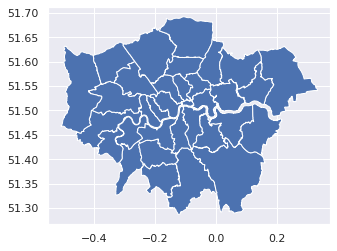

In [68]:
nbhoods.plot()

### Analyze

##### QUESTION ONE

##### How many Airbnb listings in London are not the primary residence of the host?

In [69]:
total_listings = airbnb['id'].count()
total_hosts = airbnb['host_id'].nunique()
percent_diff_h = ((total_listings-total_hosts)/total_listings)*100
list_diff_h = total_listings-total_hosts
print(f"{total_listings} total listings were offered during August 2019.")
print(f"{total_hosts} total hosts were active during August 2019.")
print(f"There were {list_diff_h} more listings ({round(percent_diff_h)}%) than hosts during August 2019.")

85918 total listings were offered during August 2019.
54438 total hosts were active during August 2019.
There were 31480 more listings (37%) than hosts during August 2019.


In [70]:
total_eh = ((airbnb['room_type'] == 'Entire home/apt').sum())
percent_diff_eh = (total_eh/total_listings)*100
print(f"{total_eh} listings ({round(percent_diff_eh)}%) offered an entire home or apartment during August 2019.")

48253 listings (56%) offered an entire home or apartment during August 2019.


In [71]:
print(airbnb.groupby('room_type').host_id.nunique())

room_type
Entire home/apt    30212
Hotel room             6
Private room       27186
Shared room          471
Name: host_id, dtype: int64


In [72]:
# We see that there were 30212 listings where the entire home or apartment were listed with unique host ids
# Now through elimination, we can calculate home many entire homes or apartments were listed by hosts with more than one listing
multi_list_host_eh = total_eh-30212
percent_multi_list_host_eh = ((multi_list_host_eh)/total_listings)*100
print(f"{multi_list_host_eh} listings ({round(percent_multi_list_host_eh)}%) during August 2019 were for an entire home or apartment and offered by hosts with multiple listings.")

18041 listings (21%) during August 2019 were for an entire home or apartment and offered by hosts with multiple listings.


##### QUESTION TWO

##### How many Airbnb listings in London can be attributed to hosts with multiple listings?

In [73]:
# let's do the same analysis for the remaining room types
total_pr = ((airbnb['room_type'] == 'Private room').sum())
total_hr = ((airbnb['room_type'] == 'Hotel room').sum())
total_sr = ((airbnb['room_type'] == 'Shared room').sum())
percent_diff_pr = (total_pr/total_listings)*100
percent_diff_hr = (total_hr/total_listings)*100
percent_diff_sr = (total_sr/total_listings)*100
print(f"{total_pr} listings ({round(percent_diff_pr)}%) offered a private room during August 2019.")
print(f"{total_hr} listings ({round(percent_diff_hr)}%) offered a hotel room during August 2019.")
print(f"{total_sr} listings ({round(percent_diff_sr)}%) offered a shared room during August 2019.")

36934 listings (43%) offered a private room during August 2019.
8 listings (0%) offered a hotel room during August 2019.
723 listings (1%) offered a shared room during August 2019.


In [74]:
print(airbnb.groupby('room_type').host_id.nunique())

room_type
Entire home/apt    30212
Hotel room             6
Private room       27186
Shared room          471
Name: host_id, dtype: int64


In [75]:
# From above, we see that there were:
    # 27186 listings where a private room was listed with unique host ids
    # 6 listings where a hotel room was listed with unique host ids
    # 471 listings where a shared room was listed with unique host ids
# Now through elimination, we can calculate home many private, hotel, and shared rooms were listed by hosts with more than one listing
multi_list_host_pr = total_pr-27186
multi_list_host_hr = total_hr-6
multi_list_host_sr = total_sr-471
percent_multi_list_host_pr = ((multi_list_host_pr)/total_listings)*100
percent_multi_list_host_hr = ((multi_list_host_hr)/total_listings)*100
percent_multi_list_host_sr = ((multi_list_host_sr)/total_listings)*100
print(f"{multi_list_host_pr} listings ({round(percent_multi_list_host_pr)}%) during August 2019 were for a private room and offered by hosts with multiple listings.")
print(f"{multi_list_host_hr} listings ({round(percent_multi_list_host_hr)}%) during August 2019 were for a hotel room and offered by hosts with multiple listings.")
print(f"{multi_list_host_sr} listings ({round(percent_multi_list_host_sr)}%) during August 2019 were for a shared room and offered by hosts with multiple listings.")

9748 listings (11%) during August 2019 were for a private room and offered by hosts with multiple listings.
2 listings (0%) during August 2019 were for a hotel room and offered by hosts with multiple listings.
252 listings (0%) during August 2019 were for a shared room and offered by hosts with multiple listings.


In [76]:
# How many total listings were from host with multiple listings?
print(f"A total of {multi_list_host_eh + multi_list_host_pr + multi_list_host_hr + multi_list_host_sr} listings ({round(percent_multi_list_host_eh + percent_multi_list_host_pr + percent_multi_list_host_hr + percent_multi_list_host_sr)}%) were offered by hosts with multiple listings.")

A total of 28043 listings (33%) were offered by hosts with multiple listings.


33889201     1175
156158778     243
28820321      223
48165024      180
137094377     163
1432477       162
224866971     157
27572615      138
13557337      118
50291093      113
Name: host_id, dtype: int64


[Text(0, 0, '33889201'),
 Text(1, 0, '156158778'),
 Text(2, 0, '28820321'),
 Text(3, 0, '48165024'),
 Text(4, 0, '137094377'),
 Text(5, 0, '1432477'),
 Text(6, 0, '224866971'),
 Text(7, 0, '27572615'),
 Text(8, 0, '13557337'),
 Text(9, 0, '50291093')]

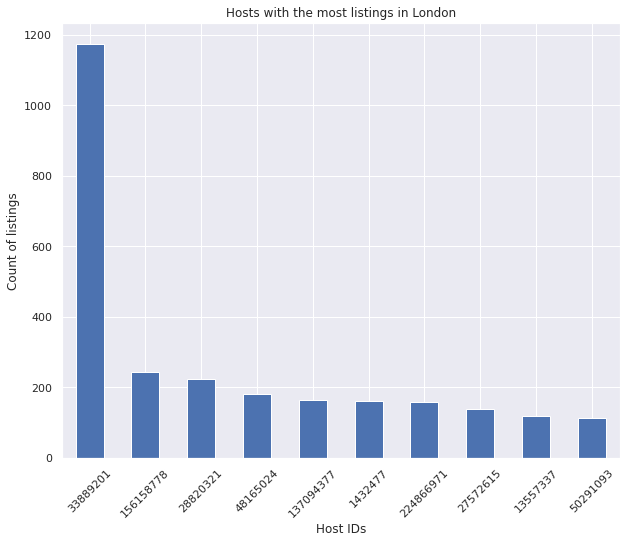

In [77]:
# What about the hosts with the most listings?
top_hosts = airbnb['host_id'].value_counts().head(10)
print(top_hosts)

sns.set(rc={'figure.figsize':(10,8)})

viz_bar = top_hosts.plot(kind='bar')
viz_bar.set_title('Hosts with the most listings in London')
viz_bar.set_xlabel('Host IDs')
viz_bar.set_ylabel('Count of listings')
viz_bar.set_xticklabels(viz_bar.get_xticklabels(), rotation=45)

In [78]:
# Look up host information for host 33889201
airbnb.set_index('host_id', inplace=True)
print(airbnb.loc['33889201', 'host_about'])

host_id
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
                                  ...                        
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
33889201    Greetings from the Veeve team!\r\n\r\nMy name ...
Name: host_about, Length: 1175, dtype: object


In [79]:
# It seems that host 33889201 is a management company called Veeve.
# Google search confirms this -> https://www.veeve.com/en-gb/ 

##### QUESTION THREE

##### How many Airbnb listings in London are operated by management companies?

In [17]:
ha = airbnb.host_about
print(ha)

0        37 years old from France. Living with my wife,...
1        Hi\r\n\r\nI expect you'd like to know somethin...
2        Hi\r\n\r\nI expect you'd like to know somethin...
3        Hi\r\n\r\nI expect you'd like to know somethin...
4        Hi\r\n\r\nI expect you'd like to know somethin...
                               ...                        
85913                                                  nan
85914                                                  nan
85915                                                  nan
85916    Hi I'm Rosi! \nI've grown up in sunny Brasil, ...
85917                                                  nan
Name: host_about, Length: 85918, dtype: object


In [18]:
# Regular Expressions
def preprocess(ha):
    clean_data = []
    for x in (ha[:]): #this is Df_pd for Df_np (text[:])
        new_ha = re.sub('<.*?>', '', x)   # remove HTML tags
        new_ha = re.sub(r'[^\w\s]', '', new_ha) # remove punc.
        new_ha = re.sub(r'\d+','',new_ha)# remove numbers
        new_ha = new_ha.lower() # lower case, .upper() for upper          
        if new_ha != '':
            clean_data.append(new_ha)
    return clean_data

In [19]:
# Word Tokenization
def tokenization_w(words):
    w_new = []
    for w in (words[:]):  # for NumPy = words[:]
        w_token = word_tokenize(w)
        if w_token != '':
            w_new.append(w_token)
    return w_new

In [20]:
# Stemming
snowball = SnowballStemmer(language = 'english')
def stemming(words):
    new = []
    stem_words = [snowball.stem(x) for x in (words[:])]
    new.append(stem_words)
    return new

In [21]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatization(words):
    new = []
    lem_words = [lemmatizer.lemmatize(x) for x in (words[:])]
    new.append(lem_words)
    return new

In [23]:
# Test

#ha_pd = pd.DataFrame(ha) #makes this into a panda data frame
#print(ha_pd)
clean_ha = preprocess(ha) #removes punctuation, see above
print(clean_ha)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
clean_words = tokenization_w(clean_ha) # word tokenization
print(clean_words)

In [ ]:
stem_ha = stemming(clean_words) # stemming similar words
print(stem_ha)

In [ ]:
lemha = lemmatization(clean_words)
print(lemha)

In [143]:
# Original
airbnb['host_about'].head()

0    37 years old from France. Living with my wife,...
1    Hi\r\n\r\nI expect you'd like to know somethin...
2    Hi\r\n\r\nI expect you'd like to know somethin...
3    Hi\r\n\r\nI expect you'd like to know somethin...
4    Hi\r\n\r\nI expect you'd like to know somethin...
Name: host_about, dtype: object

In [144]:
# Ensure all values in the column are string
airbnb['host_about'] = airbnb['host_about'].apply(str)

In [145]:
# Convert all to lower case
airbnb['host_about'] = airbnb['host_about'].apply(lambda x: " ".join(x.lower() for x in x.split()))
airbnb['host_about'].head()

0    37 years old from france. living with my wife,...
1    hi i expect you'd like to know something about...
2    hi i expect you'd like to know something about...
3    hi i expect you'd like to know something about...
4    hi i expect you'd like to know something about...
Name: host_about, dtype: object

In [146]:
# Remove punctuation
airbnb['host_about'] = airbnb['host_about'].str.replace('[^\w\s]','')
airbnb['host_about'].head()

0    37 years old from france living with my wife a...
1    hi i expect youd like to know something about ...
2    hi i expect youd like to know something about ...
3    hi i expect youd like to know something about ...
4    hi i expect youd like to know something about ...
Name: host_about, dtype: object

In [147]:
# Remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
airbnb['host_about'] = airbnb['host_about'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
airbnb['host_about'].head()

0    37 years old france living wife working london...
1    hi expect youd like know something youre comin...
2    hi expect youd like know something youre comin...
3    hi expect youd like know something youre comin...
4    hi expect youd like know something youre comin...
Name: host_about, dtype: object

In [148]:
# Look at 10 most frequent words
freq = pd.Series(' '.join(airbnb['host_about']).split()).value_counts()[:10]
freq

london      41005
nan         36521
love        25149
stay        14024
people      13252
im          12430
travel      12257
new         12231
guests      11931
property    11406
dtype: int64

In [149]:
# These words do not help in our analysis
# Remove 10 most frequent words
freq = list(freq.index)
airbnb['host_about'] = airbnb['host_about'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
airbnb['host_about'].head()

0     37 years old france living wife working designer
1    hi expect youd like know something youre comin...
2    hi expect youd like know something youre comin...
3    hi expect youd like know something youre comin...
4    hi expect youd like know something youre comin...
Name: host_about, dtype: object

In [150]:
# Look at 10 least frequent words
freq = pd.Series(' '.join(airbnb['host_about']).split()).value_counts()[-10:]
freq

expatriation          1
dellâesperienza       1
sculpting             1
heena                 1
conan                 1
exhibitionslooking    1
driverwho             1
swaying               1
cliches               1
coraãão               1
dtype: int64

In [151]:
# These words do not help in our analysis
# Remove 10 least frequent words
freq = list(freq.index)
airbnb['host_about'] = airbnb['host_about'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
airbnb['host_about'].head()

0     37 years old france living wife working designer
1    hi expect youd like know something youre comin...
2    hi expect youd like know something youre comin...
3    hi expect youd like know something youre comin...
4    hi expect youd like know something youre comin...
Name: host_about, dtype: object

In [ ]:
# Tokenization
nltk.word_tokenize(airbnb['host_about'])

In [127]:
# Stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
airbnb['host_about'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0              37 year old franc live wife work design
1    hi expect youd like know someth your come ive ...
2    hi expect youd like know someth your come ive ...
3    hi expect youd like know someth your come ive ...
4    hi expect youd like know someth your come ive ...
Name: host_about, dtype: object

In [ ]:
# Lemmatization
from textblob import Word
airbnb['host_about'] = airbnb['host_about'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
airbnb['host_about'].head()

In [46]:
# We will perfomrm an NLP to identify common words within the 'host_about' column
# Let's make sure all values in the column are string
airbnb['host_about'] = airbnb['host_about'].apply(str)

In [47]:
# Check first row to see original record
print(airbnb['host_about'][0])

37 years old from france. living with my wife, and working in london as a designer.


In [48]:
# STEP 1 - convert all text to lower case
airbnb['host_about'] = airbnb['host_about'].str.lower()

In [49]:
# STEP 2 - tokenize records and remove non alphanumeric words or characters
def identify_tokens(row):
    host_about = row['host_about']
    tokens = nltk.word_tokenize(host_about)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

airbnb['words'] = airbnb.apply(identify_tokens, axis=1)

In [50]:
# STEP 3 - remove all stopwords
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

def remove_stops(row):
    my_list = row['stemmed_words']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

airbnb['stem_meaningful'] = airbnb.apply(remove_stops, axis=1)

In [51]:
# STEP 4 - stem records to reduce related words
from nltk.stem import PorterStemmer
stemming = PorterStemmer()

def stem_list(row):
    my_list = row['words']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

airbnb['stemmed_words'] = airbnb.apply(stem_list, axis=1)

##### QUESTION FOUR

##### Is the problem of 'ghost hotels' concentrated in certain areas of London or spread throughout?

---

## Part 2 - Executive Briefing

---

### 1 Executive Summary

This report provides an analysis of Airbnb activity in London based on data sourced from the Inside Airbnb website for the month of August 2019 – the last summer month prior to the COVID-19 pandemic. Through exploratory data analysis, we define what a ‘ghost hotel’ is and then set out to answer four main questions:
1. How many Airbnb listings in London are not the primary residence of the host?
2. How many Airbnb listings in London can be attributed to hosts with multiple listings?
3. How many Airbnb listings in London are operated by management companies?
4. Is the problem of ‘ghost hotels’ concentrated in certain areas of London or spread throughout?

#### Key Findings

#### Recommendations

---

### 2 Background

#### Airbnb

#### 'Ghost Hotels'

#### Inside Airbnb

---

### 3 Analysis

#### How many Airbnb listings in London are not the primary residence of the host?

#### How many Airbnb listings in London can be attributed to hosts with multiple listings? 

#### How many Airbnb listings in London are operated by management companies? 

#### Is the problem of 'ghost hotels' concentrated in certain areas of London or spread throughout?

---

### 4 Conclusion

---

### 5 References